In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy.stats import kruskal
from scipy.stats import gaussian_kde

import sys
import os

sys.path.append(os.path.relpath("../../huygens"))
sys.path.append(os.path.relpath("../../galileo"))

import galileo as gal
import huygens as huy

from collections import Counter

plt.rcParams['ps.useafm'] = True
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

from statsmodels.stats.multitest import multipletests


# Transcripts to genes

In [2]:
t2g = pd.read_csv("../data/intermediate/sleuth_diff/ensembl_t2g.csv")
t2g["format_gene_id"] = t2g["hgnc_gene"].fillna("") + "_" + t2g["ens_gene"]

format_gene_map = dict(zip(t2g["ens_gene"],t2g["format_gene_id"]))

# Preprocess TCGA

In [146]:
tcga_genex = pd.read_hdf("../../data/processed/TCGA/TCGA_genex_norm.h5",key="tcga_genex")
tcga_cn = pd.read_hdf("../../data/processed/TCGA/tcga_cn.hdf",key="tcga_cn")
tcga_cn_thresholded = pd.read_hdf("../../data/processed/TCGA/tcga_cn_thresholded.hdf",key="tcga_cn_thresholded")

tcga_sample_info = pd.read_hdf("../../data/processed/TCGA/tcga_sample_info.hdf",
                               key="tcga_sample_info")

In [ ]:
tcga_splicing = pd.read_hdf("../../data/processed/TCGA/merged.h5",key="tcga_splicing")

tcga_splicing.index = tcga_splicing.index.map(lambda x: x[:15])

tcga_splicing = tcga_splicing[~tcga_splicing.index.duplicated(keep="first")]

normal_genex = tcga_genex[tcga_genex.index.map(lambda x: x[-2:] == "11")]
normal_splicing = tcga_splicing[tcga_splicing.index.map(lambda x: x[-2:] == "11")]

tcga_genex = tcga_genex[tcga_genex.index.map(lambda x: x[-2:] != "11")]
tcga_splicing = tcga_splicing[tcga_splicing.index.map(lambda x: x[-2:] != "11")]

## RPL22 mutants

In [150]:
rpl22_tcga = pd.read_csv("../data/raw/rpl22.tcga.data.csv")

rpl22_tcga = rpl22_tcga.dropna(subset=["sampleid"])
rpl22_tcga = rpl22_tcga.set_index("sampleid")
rpl22_tcga.index = rpl22_tcga.index.map(lambda x: x[:15])

rpl22_mut = rpl22_tcga["rpl22mut.mc3.k15"].dropna()

In [151]:
rpl22_info = pd.concat([rpl22_mut.rename("RPL22_k15"),
                        tcga_cn_thresholded["RPL22"].rename("RPL22_cn")],
                       axis=1,
                       sort=True,
                       join="inner"
                       )

# Boxplots

In [152]:
def rpl22_status(row):
    if row["RPL22_k15"]:
        return "K15.fs"

    else:
        return "ΔCN=" + str(int(row["RPL22_cn"]))


rpl22_info["RPL22_status"] = rpl22_info.apply(rpl22_status, axis=1)

rpl22_order = ["K15.fs",
               "ΔCN=-2",
               "ΔCN=-1",
               "ΔCN=0",
               "ΔCN=1",
               "ΔCN=2"
               ]

mut_hue = "#e23e57"
wt_hue = "#eaeaea"

rpl22_hues = dict(zip(rpl22_order, [mut_hue]+[wt_hue]*5))

In [175]:
def plot_rpl22(y, ylabel="y"):

    plt.figure(figsize=(4, 3))

    ax = plt.subplot(111)

    rpl22_info_join = rpl22_info.join(y.dropna(), how="inner")

    rpl22_counts = rpl22_info_join["RPL22_status"].value_counts()

    grouped_y = rpl22_info_join.groupby("RPL22_status")[y.name].apply(list)
    grouped_y = list(grouped_y)

    pval = kruskal(*grouped_y)[1]

    flierprops = dict(marker='.', markersize=8,
                      markerfacecolor=(0, 0, 0, 0),
                      markeredgecolor="black",
                      markeredgewidth=0.5)

    sns.boxplot(
        rpl22_info["RPL22_status"],
        y,
        notch=True,
        order=rpl22_order,
        bootstrap=1000,
        palette=rpl22_hues,
        flierprops=flierprops
    )

    plt.xlabel("RPL22 status")
    plt.ylabel(ylabel)

    if pval == 0:
        plt.text(0.05, 1.025,
                 "P < " + huy.as_si(10**(-320), 2),
                 transform=ax.transAxes
                 )

    else:
        plt.text(0.05, 1.025,
                 "P = " + huy.as_si(pval, 2),
                 transform=ax.transAxes
                 )

    xticks = [x + "\n ("+str(int(rpl22_counts.loc[x])) +
              ")" for x in rpl22_order]

    ax.set_xticklabels(xticks)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.spines['left'].set_position(('axes', -0.025))
    ax.spines['bottom'].set_position(('axes', -0.025))

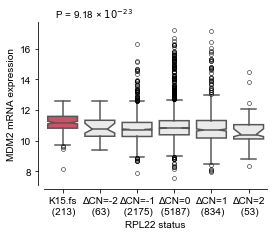

In [176]:
plot_rpl22(tcga_genex["MDM2_10743"],
           "MDM2 mRNA expression"
           )

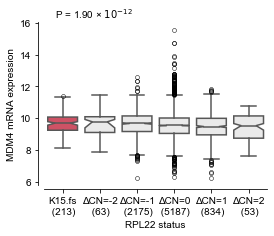

In [177]:
plot_rpl22(tcga_genex["MDM4_10744"],
           "MDM4 mRNA expression"
           )

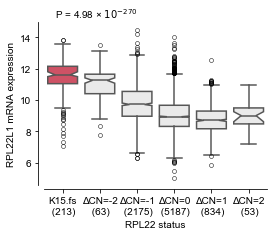

In [178]:
plot_rpl22(tcga_genex["RPL22L1_15209"],
           "RPL22L1 mRNA expression"
           )

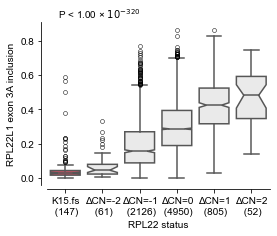

In [179]:
plot_rpl22(1-tcga_splicing["RPL22L1_ENSG00000163584_ENSG00000163584.13_A3_3_170586086:170586168:170585801:170585923:170585801:170585990_170585923:170585990"],
           "RPL22L1 exon 3A inclusion"
           )

plt.savefig("../plots/rpl22l1-exon-3a_rpl22_tcga.pdf",
            bbox_inches="tight", transparent=True)

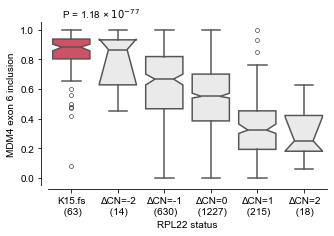

In [159]:
plot_rpl22(tcga_splicing["MDM4_ENSG00000198625_ENSG00000198625.8_ES_1_204501318:204501374:204506557:204506625:204507336:204507436_204506557:204506625"],
           "MDM4 exon 6 inclusion",
           )

plt.savefig("../plots/mdm4-exon-6_rpl22_tcga.pdf",
            bbox_inches="tight", transparent=True)

In [57]:
rpl22_mdm4 = pd.concat([tcga_splicing["RPL22L1_ENSG00000163584_ENSG00000163584.13_A3_3_170586086:170586168:170585801:170585923:170585801:170585990_170585923:170585990"].rename("RPL22L1_3A").dropna(),
                        tcga_cn_thresholded["RPL22"].dropna()
                       ],join="inner",axis=1)

rpl22_neutral = rpl22_mdm4[rpl22_mdm4["RPL22"]==0]



In [62]:
corrs = gal.mat_corrs_naive(rpl22_neutral["RPL22L1_3A"],tcga_splicing,pbar=True)

# Scatterplots

In [45]:
def density_scatter(x, y):

    x = x.dropna()
    y = y.dropna()

    x, y = x.align(y, join="inner")

    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    plt.figure(figsize=(3, 3))
    ax = plt.subplot(111)

    ax.scatter(x, y,
               c=z,
               s=8,
               cmap="Blues",
               rasterized=True,
               vmin=min(z)-1
               )

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    return ax

## RPL22L1 3A vs expression

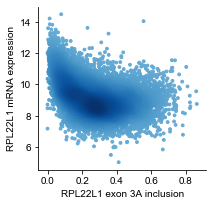

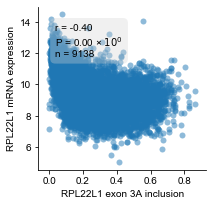

In [15]:
x = 1-tcga_splicing["RPL22L1_ENSG00000163584_ENSG00000163584.13_A3_3_170586086:170586168:170585801:170585923:170585801:170585990_170585923:170585990"]
y = tcga_genex["RPL22L1_15209"]

ax = density_scatter(x, y)

ax.set_xlabel("RPL22L1 exon 3A inclusion")
ax.set_ylabel("RPL22L1 mRNA expression")

plt.savefig("../plots/rpl22l1_splicing_expression_density.pdf",
            dpi=2048, bbox_inches="tight", background="transparent")

plt.figure(figsize=(3, 3))

huy.regression(x, y)

plt.xlabel("RPL22L1 exon 3A inclusion")
plt.ylabel("RPL22L1 mRNA expression")

plt.savefig("../plots/rpl22l1_splicing_expression_annotated.pdf",
            dpi=2048, bbox_inches="tight", background="transparent")

## RPL22L1 3A vs MDM4 6

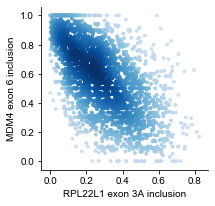

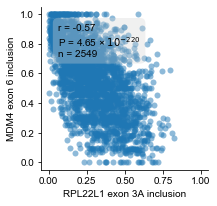

In [17]:
x = 1-tcga_splicing["RPL22L1_ENSG00000163584_ENSG00000163584.13_A3_3_170586086:170586168:170585801:170585923:170585801:170585990_170585923:170585990"]
y = tcga_splicing["MDM4_ENSG00000198625_ENSG00000198625.8_ES_1_204501318:204501374:204506557:204506625:204507336:204507436_204506557:204506625"]

ax = density_scatter(x, y)

ax.set_xlabel("RPL22L1 exon 3A inclusion")
ax.set_ylabel("MDM4 exon 6 inclusion")

plt.savefig("../plots/rpl22l1_mdm4_co-splicing_density.pdf",
            dpi=2048, bbox_inches="tight", background="transparent")

plt.figure(figsize=(3, 3))

huy.regression(x, y)

plt.xlabel("RPL22L1 exon 3A inclusion")
plt.ylabel("MDM4 exon 6 inclusion")

plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)

plt.savefig("../plots/rpl22l1_mdm4_co-splicing_annotated.pdf",
            dpi=2048, bbox_inches="tight", transparent=True)

# TCGA correlations

In [93]:
rpl22_cn_splicing = pd.read_hdf(
    "../data/intermediate/rpl22_cn_splicing.h5", key="rpl22_cn_splicing")

rpl22l1_genex_splicing = pd.read_hdf(
    "../data/intermediate/rpl22l1_genex_splicing.h5", key="rpl22l1_genex_splicing")
rpl22l1_genex_splicing_subtyped = pd.read_hdf("../data/intermediate/rpl22l1_genex_splicing_subtyped.h5",
                                              key="rpl22l1_genex_splicing_subtyped")

mdm4_splicing_genex = pd.read_hdf(
    "../data/intermediate/mdm4_splicing_genex.h5", key="mdm4_splicing_genex")

rpl22l1_splicing_genex = pd.read_hdf(
    "../data/intermediate/rpl22l1_splicing_genex.h5", key="rpl22l1_splicing_genex")

mdm4_splicing_genex_subtyped = pd.read_hdf(
    "../data/intermediate/mdm4_splicing_genex_subtyped.h5", key="mdm4_splicing_genex_subtyped")

rpl22l1_splicing_genex_subtyped = pd.read_hdf(
    "../data/intermediate/rpl22l1_splicing_genex_subtyped.h5", key="rpl22l1_splicing_genex_subtyped")

mdm4_cosplicing = pd.read_hdf(
    "../data/intermediate/mdm4_cosplicing.h5", key="mdm4_cosplicing")

rpl22l1_cosplicing = pd.read_hdf(
    "../data/intermediate/rpl22l1_cosplicing.h5", key="rpl22l1_cosplicing")

mdm4_cosplicing_subtyped = pd.read_hdf(
    "../data/intermediate/mdm4_cosplicing_subtyped.h5", key="mdm4_cosplicing_subtyped")
rpl22l1_cosplicing_subtyped = pd.read_hdf(
    "../data/intermediate/rpl22l1_cosplicing_subtyped.h5", key="rpl22l1_cosplicing_subtyped")

rpl22l1_genex_splicing_subtyped = rpl22l1_genex_splicing_subtyped[rpl22l1_genex_splicing_subtyped["n"] >= 250]
mdm4_splicing_genex_subtyped = mdm4_splicing_genex_subtyped[mdm4_splicing_genex_subtyped["n"] >= 100]
rpl22l1_splicing_genex_subtyped = rpl22l1_splicing_genex_subtyped[rpl22l1_splicing_genex_subtyped["n"] >= 250]
mdm4_cosplicing_subtyped = mdm4_cosplicing_subtyped[mdm4_cosplicing_subtyped["n"] >= 100]
rpl22l1_cosplicing_subtyped = rpl22l1_cosplicing_subtyped[rpl22l1_cosplicing_subtyped["n"] >= 250]

## Overall correlations

In [90]:
def volcano(corrs):
    corrs = corrs.sort_values(by="pval")
    corrs["qval"] = multipletests(
        10**(-corrs["pval"]), alpha=0.01, method="fdr_bh")[1]

    labels = pd.Series(corrs.index.map(
        lambda x: x.split("_")[0]), index=corrs.index)

    pos_ranks = corrs[corrs["corr"]>0]["qval"].rank()
    neg_ranks = corrs[corrs["corr"]<0]["qval"].rank()
    ranks = pd.concat([pos_ranks,neg_ranks])

    corrs["qval_rank"] = ranks
    
    pos_ranks = (-corrs[corrs["corr"]>0]["corr"]).rank()
    neg_ranks = corrs[corrs["corr"]<0]["corr"].rank()
    ranks = pd.concat([pos_ranks,neg_ranks])
    
    corrs["corr_rank"] = ranks

    ranks = pd.concat([pos_ranks,neg_ranks])

    huy.dense_plot(corrs["corr"],
                   -np.log10(corrs["qval"]),
                   labels_mask=(corrs["corr_rank"] < 6)|(corrs["qval_rank"] < 6),
                   labels=labels,
                   adjust=False,
                   c="black"
                   )
    
    plt.xlabel("Spearman correlation")
    plt.ylabel("-log10(q-value)")    

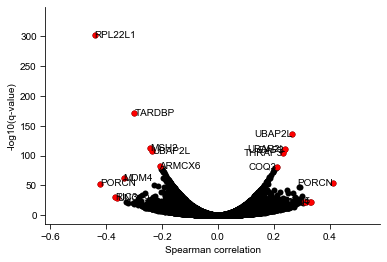

In [111]:
volcano(rpl22_cn_splicing)
plt.savefig("../plots/RPL22_cn_vs_splicing.pdf",
            bbox_inches="tight", transparent=True, dpi=512)

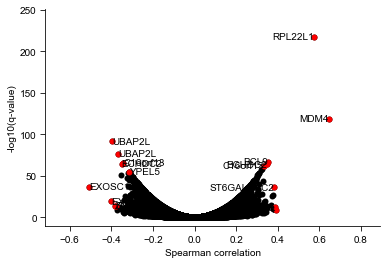

In [110]:
volcano(mdm4_cosplicing)
plt.savefig("../plots/MDM4_cosplicing.pdf",
            bbox_inches="tight", transparent=True, dpi=512)

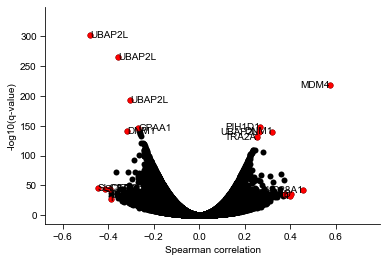

In [109]:
volcano(rpl22l1_cosplicing)
plt.savefig("../plots/RPL22L1_cosplicing.pdf",
            bbox_inches="tight", transparent=True, dpi=512)

## Subtype correlations

In [94]:
rpl22l1_gene = "RPL22L1_15209"
rpl22l1_exon_3a = "RPL22L1_ENSG00000163584_ENSG00000163584.13_A3_3_170586086:170586168:170585801:170585923:170585801:170585990_170585923:170585990"
mdm4_exon_6 = "MDM4_ENSG00000198625_ENSG00000198625.8_ES_1_204501318:204501374:204506557:204506625:204507336:204507436_204506557:204506625"

In [95]:
# reset indices
rpl22l1_genex_splicing_subtyped = rpl22l1_genex_splicing_subtyped.set_index(rpl22l1_gene)

mdm4_splicing_genex_subtyped = mdm4_splicing_genex_subtyped.set_index(mdm4_exon_6)
rpl22l1_splicing_genex_subtyped = rpl22l1_splicing_genex_subtyped.set_index(rpl22l1_exon_3a)

mdm4_cosplicing_subtyped = mdm4_cosplicing_subtyped.set_index(mdm4_exon_6)
rpl22l1_cosplicing_subtyped = rpl22l1_cosplicing_subtyped.set_index(rpl22l1_exon_3a)

# remove self correlations

mdm4_cosplicing = mdm4_cosplicing[mdm4_cosplicing.index.map(lambda x: x!=mdm4_exon_6)]
rpl22l1_cosplicing = rpl22l1_cosplicing[rpl22l1_cosplicing.index.map(lambda x: x!=rpl22l1_exon_3a)]

mdm4_cosplicing_subtyped = mdm4_cosplicing_subtyped[mdm4_cosplicing_subtyped.index.map(lambda x: x!=mdm4_exon_6)]
rpl22l1_cosplicing_subtyped = rpl22l1_cosplicing_subtyped[rpl22l1_cosplicing_subtyped.index.map(lambda x: x!=rpl22l1_exon_3a)]

In [119]:
def plot_subtype_corrs(corrs):

    subtype_diseases = sorted(list(set(corrs["abbreviated_disease"])))

    fig, axes = plt.subplots(1, len(subtype_diseases), figsize=(
        len(subtype_diseases), 4), sharey=True)

    for subtype_idx, subtype in enumerate(subtype_diseases):

        ax = axes[subtype_idx]

        subtype_corrs = corrs[corrs["abbreviated_disease"] == subtype]
        subtype_corrs = subtype_corrs.sort_values(by="pval")
        subtype_corrs["qval"] = multipletests(
            10**(-subtype_corrs["pval"]), alpha=0.01, method="fdr_bh")[1]

        subtype_corrs["sign"] = subtype_corrs["corr"].apply(
            lambda x: -1 if x <= 0 else 1)

        subtype_corrs["signed_qval"] = subtype_corrs["sign"] * \
            (-np.log10(subtype_corrs["qval"]))
        subtype_corrs["signed_qval_rank"] = subtype_corrs["signed_qval"].rank()

        subtype_labels = pd.Series(subtype_corrs.index.map(
            lambda x: x.split("_")[0]), index=subtype_corrs.index)

        pos_ranks = (-subtype_corrs[subtype_corrs["corr"] > 0]["corr"]).rank()
        neg_ranks = subtype_corrs[subtype_corrs["corr"] < 0]["corr"].rank()

        ranks = pd.concat([pos_ranks, neg_ranks])

        subtype_corrs["rank"] = ranks

        huy.dense_plot(subtype_corrs["signed_qval_rank"]/len(subtype_corrs)-1,
                       subtype_corrs["corr"],
                       labels_mask=subtype_corrs["rank"] < 3,
                       labels=subtype_labels,
                       adjust=False,
                       ax=ax,
                       c="black"
                       )

        ax.set_xticks([])
        ax.set_xlabel(subtype)

        ax.axhline(c="black")
        
        if subtype_idx == 0:
            ax.set_ylabel("Spearman correlation")

        if subtype_idx % 2 == 1:
            ax.patch.set_facecolor('black')
            ax.patch.set_alpha(0.05)
        else:
            ax.patch.set_alpha(0)

        if subtype_idx > 0:
            ax.spines["left"].set_visible(False)
            ax.tick_params(axis=u'both', which=u'both', length=0)

#     ax.set_ylim(-50,75)
    ax.set_ylim(-0.8, 0.8)

#     fig.text(0.5, 0.08, 'Spearman correlation', ha='center')
#     fig.text(0, 0.5, 'Spearman correlation', va='center', rotation='vertical')

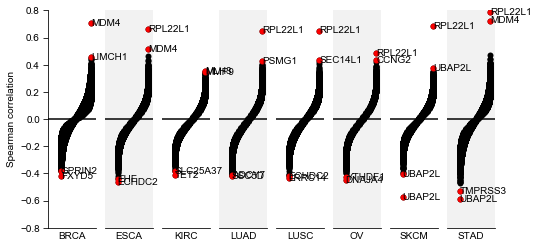

In [120]:
plot_subtype_corrs(mdm4_cosplicing_subtyped)

plt.savefig("../plots/MDM4_cosplicing_subtypes.pdf",dpi=512,transparent=True,bbox_inches="tight")

In [112]:
plot_subtype_corrs(rpl22l1_cosplicing_subtyped, (4, 6), (16, 16))

plt.savefig("../plots/RPL22L1_cosplicing_subtyped.pdf",
            bbox_inches="tight", transparent=True, dpi=512)

plt.clf()

<Figure size 1152x1152 with 0 Axes>

In [113]:
plot_subtype_corrs(mdm4_cosplicing_subtyped,(2,4),(12,8))

plt.savefig("../plots/MDM4_cosplicing_subtyped.pdf",
            bbox_inches="tight", transparent=True, dpi=512)

plt.clf()

<Figure size 864x576 with 0 Axes>

# RPL22 alterations by primary site

In [169]:
rpl22_subtype_info = rpl22_info.join(
    tcga_sample_info["abbreviated_disease"], how="inner")

subtype_proportions = rpl22_subtype_info.groupby(["abbreviated_disease"])[
    "RPL22_status"].value_counts()
subtype_proportions = subtype_proportions.unstack().fillna(0)

subtype_totals = subtype_proportions.sum(axis=1)

subtype_proportions = subtype_proportions.div(subtype_totals, axis=0)*100
subtype_proportions["total"] = subtype_totals.astype(int)

altered_classes = [
    "ΔCN=-1",
    "ΔCN=-2",
    "K15.fs",
]

subtype_proportions["altered_proportion"] = subtype_proportions[altered_classes].sum(
    axis=1)
subtype_proportions = subtype_proportions.sort_values(
    by="altered_proportion", ascending=False)

subtype_proportions["display_disease"] = subtype_proportions.index
subtype_proportions["display_disease"] = subtype_proportions["display_disease"] + \
    " (" + subtype_proportions["total"].astype(str) + ")"

subtype_proportions = subtype_proportions[subtype_proportions["total"]>=50]

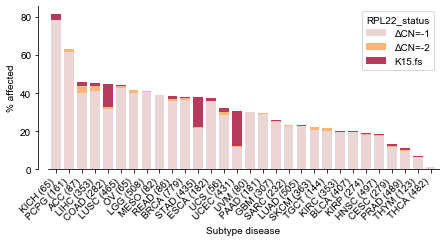

In [182]:
plt.figure(figsize=(7, 3))

ax = plt.subplot(111)

subtype_proportions.plot(x="display_disease",
                         y=altered_classes,
                         kind="bar",
                         stacked=True,
                         cmap=mpl.colors.ListedColormap(
                             ["#ebd5d5", "#fab57a", "#b83b5e"]),
                         ax=ax,
                         width=0.75
                         )

plt.xlabel("Subtype disease")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('axes', -0.025))

plt.xticks(rotation=45, ha="right")

plt.ylabel("% affected")

plt.savefig("../plots/rpl22_subtype_distribution.pdf",
            bbox_inches="tight", transparent=True)

# CCLE

In [251]:
ccle_genex = pd.read_hdf(
    "../../data/processed/ccle/CCLE_RNAseq_rsem_genes_tpm_20180929.hdf", key="ccle_genex")
ccle_transcripts = pd.read_hdf("../../data/processed/ccle/CCLE_RNAseq_rsem_transcripts_tpm_20180929.hdf",
                        key="ccle_transcripts")
exonusage = pd.read_hdf(
    "../../data/processed/ccle/CCLE_RNAseq_ExonUsageRatio_20180929.hdf", key="exonusage")
ms_prot = pd.read_hdf("../../data/processed/ccle/ms_prot.h5",key="ms_prot")
rppa = pd.read_hdf("../../data/processed/ccle/CCLE_RPPA_20181003.hdf",key="rppa")

mdm4_exon_6 = exonusage[["MDM4_3p_chr1_204506558_204506625_ENSG00000198625.8",
                         "MDM4_5p_chr1_204506558_204506625_ENSG00000198625.8"
                        ]].mean(axis=1)

avana = pd.read_hdf("../../data/processed/depmap/avana.hdf",key="avana")
drive = pd.read_hdf("../../data/processed/depmap/demeter2-drive_v12-gene-effect.hdf",key="drive")

In [287]:
primary_logfold = pd.read_hdf("../../data/processed/depmap/primary_logfold.h5",key="primary_logfold")
secondary_logfold = pd.read_hdf("../../data/processed/depmap/secondary_logfold.h5",key="secondary_logfold")

In [297]:
ubap2l_tx = ccle_transcripts[[x for x in ccle_transcripts.columns if "UBAP2L" in x]]
ubap2l_exons = exonusage[[x for x in exonusage.columns if "UBAP2L" in x]]

## RPPA correlations

In [124]:
mdm4_rppa = pd.concat([
    ccle_genex["MDM4_ENSG00000198625.8"].rename("MDM4_genex"),
    mdm4_exon_6.rename("MDM4_exon_6"),
    rppa["MDMX_MDM4(BetIHC-00108)_Caution"].rename("MDM4_protein")
],axis=1,sort=True)

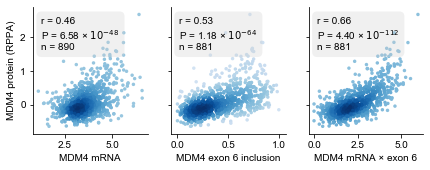

In [129]:
fig, axes = plt.subplots(1, 3, figsize=(7, 7/3), sharey=True)

text_pos = (0.075, 0.925)

ax = axes[0]
huy.dense_regression(mdm4_rppa["MDM4_genex"],
                     mdm4_rppa["MDM4_protein"],
                     ax=ax,
                     s=12,
                     text_pos=text_pos
                     )
ax.set_ylabel("MDM4 protein (RPPA)")
ax.set_xlabel("MDM4 mRNA")

ax = axes[1]
huy.dense_regression(mdm4_rppa["MDM4_exon_6"],
                     mdm4_rppa["MDM4_protein"],
                     ax=ax,
                     s=12,
                     text_pos=text_pos
                     )
ax.set_xlabel("MDM4 exon 6 inclusion")

mult = np.log2(2**mdm4_rppa["MDM4_genex"]*mdm4_rppa["MDM4_exon_6"]+1)

ax = axes[2]
huy.dense_regression(mult,
                     mdm4_rppa["MDM4_protein"],
                     ax=ax,
                     s=12,
                     text_pos=text_pos
                     )

ax.set_xlabel("MDM4 mRNA × exon 6")

plt.savefig("../plots/MDM4_RPPA_correlations.pdf",
            bbox_inches="tight", transparent=True,dpi=512)

## Mass-spec correlations

In [194]:
mdm4_ms = pd.concat([
    ccle_genex["MDM4_ENSG00000198625.8"].rename("MDM4_genex"),
    mdm4_exon_6.rename("MDM4_exon_6"),
    ms_prot["MDM4_HUMAN_O15151"].rename("MDM4_protein")
],axis=1,sort=True)

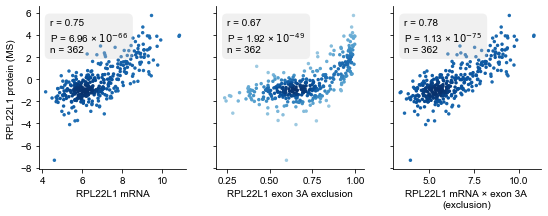

In [193]:
fig, axes = plt.subplots(1, 3, figsize=(7, 7/3), sharey=True)

text_pos = (0.075, 0.925)

ax = axes[0]
huy.regression(mdm4_ms["MDM4_genex"],
               mdm4_ms["MDM4_protein"],
               ax=ax,
               s=16,
               text_pos=text_pos,
               alpha=1,
               c="black"
               )
ax.set_ylabel("MDM4 protein (MS)")
ax.set_xlabel("MDM4 mRNA")

ax = axes[1]
huy.regression(mdm4_ms["MDM4_exon_6"],
               mdm4_ms["MDM4_protein"],
               ax=ax,
               s=16,
               text_pos=text_pos,
               alpha=1,
               c="black"
               )
ax.set_xlabel("MDM4 exon 6 inclusion")
ax.set_xlim(0, 1)
ax.set_xticks([0, 0.5, 1])

mult = np.log2(2**mdm4_ms["MDM4_genex"]*mdm4_ms["MDM4_exon_6"]+1)

ax = axes[2]
huy.regression(mult,
               mdm4_ms["MDM4_protein"],
               ax=ax,
               s=16,
               text_pos=text_pos,
               alpha=1,
               c="black"
               )

ax.set_xlabel("MDM4 mRNA × exon 6")

ax.set_ylim(ax.set_ylim()[0], ax.set_ylim()[1]*1.75)

plt.savefig("../plots/MDM4_MS_correlations.pdf",
            bbox_inches="tight", transparent=True, dpi=512)